In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

SEEDS = [5,26,47,76,92]

ENVIRONMENT_NAME = "MOLunarLanderDR-v0" # CHANGE THIS TO THE NAME OF THE ENVIRONMENT
METRIC = "NHGR" # CHANGE THIS TO THE DESIRED METRIC

In [16]:
from helpers.utils import ENVIRONMENTS_MAP, ENVIRONMENT_TO_ALGORITHMS_MAP, \
ALGORITHMS_NAME_MAP, ALGORITHMS_COLOR_MAP

# Get the algorithms for the type of environment (e.g. discrete, continuous, pixel)
ALGORITHMS = ENVIRONMENT_TO_ALGORITHMS_MAP[ENVIRONMENT_NAME]
# Get the evaluation environemnts for the domain
ENVIRONMENTS = ENVIRONMENTS_MAP[ENVIRONMENT_NAME]

KeyError: 'MOLunarLanderDR-v5'

In [17]:
def load_scores(env_id, algorithms, seeds, metric):
    scores = {}
    for algorithm in algorithms:
        algorithm_name = ALGORITHMS_NAME_MAP[algorithm]
        scores[algorithm_name] = {}
        for env in ENVIRONMENTS:
            for seed in seeds:
                df = pd.read_csv(f"data/scores/{env_id}/{algorithm}/seed_{seed}.csv")
                metric_values = df[metric + f"/{env}"].values
                scores[algorithm_name].setdefault(env, []).extend(metric_values)
    return scores

def convert_to_matrix(score_dict):
    keys = sorted(list(score_dict.keys()))
    return np.stack([score_dict[k] for k in keys], axis=1)

In [13]:
scores_dict = load_scores(ENVIRONMENT_NAME, ALGORITHMS, SEEDS, METRIC)
for algo in scores_dict.keys():
    scores_dict[algo] = convert_to_matrix(scores_dict[algo])
scores_dict

{'MORL-D(SB+PSA)': array([[0.44545782, 0.27332118, 0.64299447, 0.15069667, 0.31342479],
        [0.45456178, 0.32225046, 0.735872  , 0.129261  , 0.32997421],
        [0.45845806, 0.34118194, 0.62208955, 0.14344953, 0.33456414],
        [0.5212762 , 0.26659256, 0.69909108, 0.14403617, 0.35318058],
        [0.51933637, 0.28038791, 0.66466863, 0.12605486, 0.33626985]]),
 'MORL-D(SB)': array([[0.41071854, 0.21956843, 0.69148837, 0.11756886, 0.27717277],
        [0.47533144, 0.23536078, 0.67825427, 0.12235679, 0.31872165],
        [0.44642438, 0.34506054, 0.7139895 , 0.12390771, 0.30386135],
        [0.42262158, 0.24555992, 0.64611504, 0.09975975, 0.22468362],
        [0.42593913, 0.24059931, 0.65942007, 0.10487065, 0.31650734]]),
 'GPI-PD': array([[0.02313533, 0.        , 0.        , 0.        , 0.        ],
        [0.01149486, 0.00105754, 0.        , 0.        , 0.        ],
        [0.01356029, 0.        , 0.        , 0.        , 0.        ],
        [0.01988547, 0.        , 0.        ,

Best algorithm: CAPQL


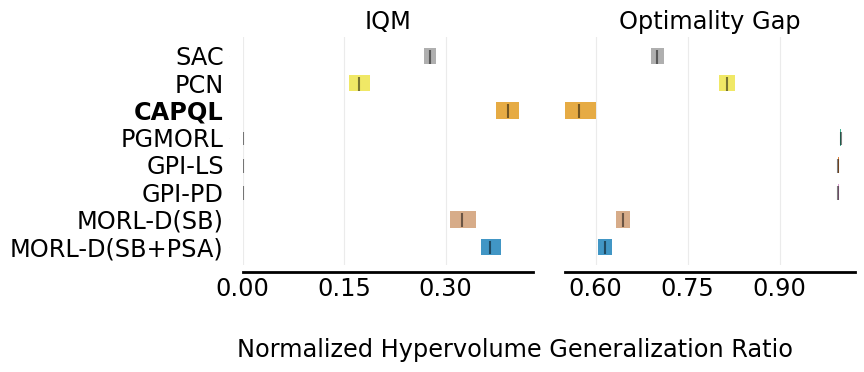

Aggregate scores: {'MORL-D(SB+PSA)': array([0.36633608, 0.61566193]), 'MORL-D(SB)': array([0.32409469, 0.64536553]), 'GPI-PD': array([8.13494007e-05, 9.96202993e-01]), 'GPI-LS': array([4.45010676e-05, 9.96011066e-01]), 'PGMORL': array([0.        , 0.99976359]), 'CAPQL': array([0.39191763, 0.57288295]), 'PCN': array([0.17207068, 0.81398219]), 'SAC': array([0.27731276, 0.70050581])}
Aggregate interval estimates: {'MORL-D(SB+PSA)': array([[0.35307104, 0.60471251],
       [0.38169018, 0.62617594]]), 'MORL-D(SB)': array([[0.30602165, 0.63339039],
       [0.34542174, 0.65644608]]), 'GPI-PD': array([[0.00000000e+00, 9.95301411e-01],
       [2.85046914e-04, 9.97110491e-01]]), 'GPI-LS': array([[4.43713531e-05, 9.95291251e-01],
       [4.46233027e-05, 9.96906420e-01]]), 'PGMORL': array([[0.        , 0.99929078],
       [0.        , 1.        ]]), 'CAPQL': array([[0.37443865, 0.54948809],
       [0.40838467, 0.60074469]]), 'PCN': array([[0.15709971, 0.80105982],
       [0.1879886 , 0.82712188]]),

In [14]:
from rliable import library as rly
from rliable import metrics
from helpers.rliable import plot_interval_estimates

IQM = lambda x: metrics.aggregate_iqm(x)                    # Interquartile Mean
OG = lambda x: metrics.aggregate_optimality_gap(x, 1.0)     # Optimality Gap

aggregate_func = lambda x: np.array([IQM(x), OG(x)])
aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(
    scores_dict, aggregate_func, reps=50000)

fig, axes = plot_interval_estimates(
    aggregate_scores, 
    aggregate_interval_estimates,
    metric_names = ['IQM', 'Optimality Gap'],
    algorithms=list(scores_dict.keys()),
    colors=ALGORITHMS_COLOR_MAP,
    xlabel_y_coordinate=-0.2,
    bold_best=True, # Bold the best algorithm
    # subfigure_width=3.6,
    # max_ticks=3,
    xlabel='Normalized Hypervolume Generalization Ratio')

# Change svg to png/jpg if you want to save the figure in a different bitmap format
plt.savefig(f'images/{ENVIRONMENT_NAME}_{METRIC}_IQM_OG.svg', format='svg', bbox_inches='tight')
plt.show()

print("Aggregate scores:", aggregate_scores)
print("Aggregate interval estimates:", aggregate_interval_estimates)

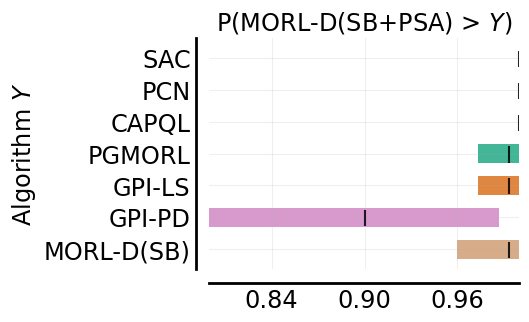

In [15]:
from matplotlib.ticker import MaxNLocator
from rliable import plot_utils

all_pairs = {}
best_algo = 'MORL-D(SB+PSA)'
for alg_y in (scores_dict.keys()):
  if alg_y == best_algo:
    continue
  pair_name = f'{best_algo},{alg_y}'
  all_pairs[pair_name] = (scores_dict[best_algo], scores_dict[alg_y]) 

probabilities, probability_cis = {}, {}
probabilities, probability_cis = rly.get_interval_estimates(all_pairs, metrics.probability_of_improvement, reps=2000)

fig, ax = plt.subplots(figsize=(4, 3))
h = 0.6
algorithm_labels = []

for i, (alg_pair, prob) in enumerate(probabilities.items()):
  _, alg1 = alg_pair.split(',')
  algorithm_labels.append(alg1)
  (l, u) = probability_cis[alg_pair]
  ax.barh(y=i, width=u-l, height=h, left=l, color=ALGORITHMS_COLOR_MAP[alg1], alpha=0.75)
  ax.vlines(x=prob, ymin=i-7.5 * h/16, ymax=i+(6*h/16), color='k', alpha=0.85)
ax.set_yticks(range(len(algorithm_labels)))
ax.set_yticklabels(algorithm_labels)


ax.set_title(fr'P({best_algo} > $Y$)', size='xx-large')
plot_utils._annotate_and_decorate_axis(ax, labelsize='xx-large', ticklabelsize='xx-large')
ax.set_ylabel(r'Algorithm $Y$', size='xx-large')
ax.xaxis.set_major_locator(MaxNLocator(4))
fig.subplots_adjust(wspace=0.25, hspace=0.45)

plt.savefig(f'images/{ENVIRONMENT_NAME}_PROB_IMPROVEMENT.png', format='png', bbox_inches='tight')
plt.show()